In [37]:
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt

In [38]:
def reconstruct_image(U, s, Vt, k):
    U_k = U[:, :k]
    S_k = np.diag(s[:k])
    Vt_k = Vt[:k, :]
    return U_k @ S_k @ Vt_k

In [39]:
def reconstruction_error(A, A_k):
    return (np.linalg.norm(A - A_k, 'fro')**2 / np.linalg.norm(A, 'fro')**2)*100

In [40]:
def compression_ratio(m, n, k):
    return (m*n) /(m*k + n*k + k)

(512, 512)
(512, 512)
(512, 512) (512, 512) (512, 512)


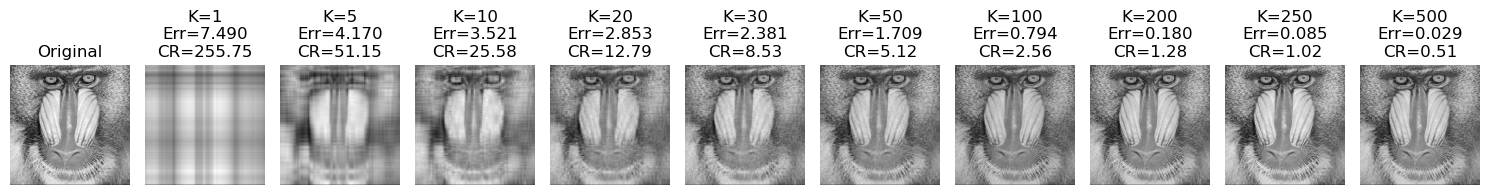

(225, 225)
(225, 225)
(225, 225) (225, 225) (225, 225)


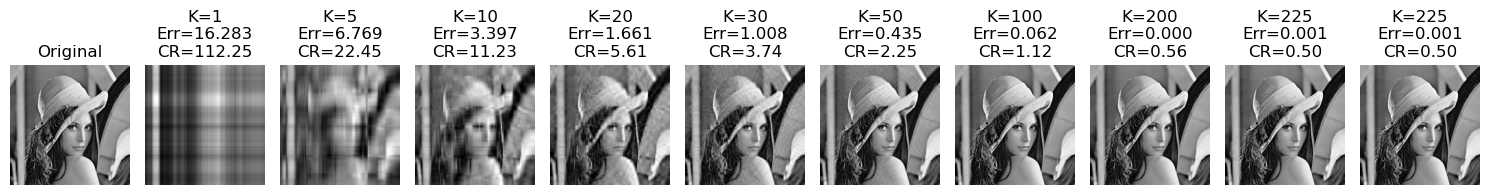

(348, 348)
(330, 330)
(348, 330) (348, 330) (330, 330)


c:\Users\sahil\anaconda3\Lib\site-packages\numpy\lib\_index_tricks_impl.py:946: ComplexWarning: Casting complex values to real discards the imaginary part
  a.flat[:end:step] = val


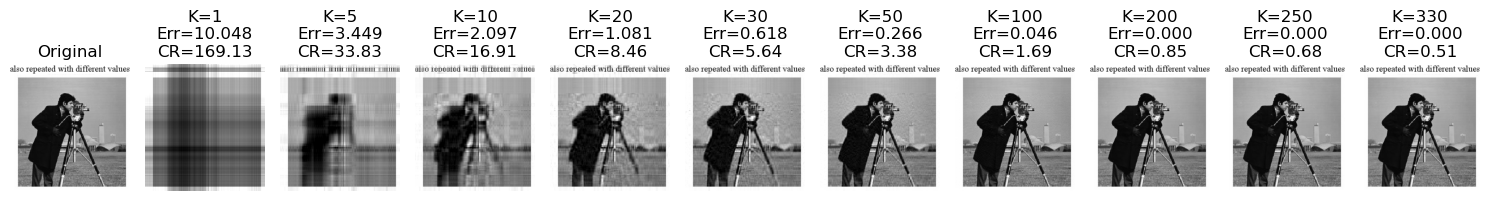

In [41]:
for l in range(1,4):
    path=f"greyscale{l}.png"
    vecImg=io.imread(path)
    vecImg.shape
    vecImg = vecImg.astype(np.float64)/255.0
    m,n=vecImg.shape
    AAT=np.dot(vecImg,vecImg.T)
    print(AAT.shape)
    eigenval,eigenvec=np.linalg.eig(AAT)
    ATA=np.dot(vecImg.T,vecImg)
    print(ATA.shape)
    eigenvalT,eigenvecT=np.linalg.eig(ATA)
    idx = np.argsort(eigenval)[::-1]   
    eigenval = eigenval[idx]
    eigenvec = eigenvec[:, idx]

    idx = np.argsort(eigenvalT)[::-1]
    eigenvalT = eigenvalT[idx]
    eigenvecT = eigenvecT[:, idx]
    
    V=eigenvecT
    U=vecImg@V/np.sqrt(eigenvalT[idx])
    singular_vals = np.sqrt(np.maximum(eigenval, 0)) 
    Sigma = np.zeros((U.shape[0], V.shape[0]))
    np.fill_diagonal(Sigma, singular_vals)
    print(U.shape,Sigma.shape,V.shape)
    k_list = [1,5,10, 20,30, 50, 100, 200,min(n,250),min(n,500)]
    errors = []
    ratios = []
    plt.figure(figsize=(15, 8))
    plt.subplot(2, len(k_list)+1, 1)
    plt.imshow(vecImg, cmap="gray")
    plt.title("Original")
    plt.axis("off")
    for i, k in enumerate(k_list, start=2):
        A_k = reconstruct_image(U, singular_vals, V.T, k)
        A_k = np.clip(np.real(A_k), 0, 1)
        err = reconstruction_error(vecImg, A_k)
        cr = compression_ratio(vecImg.shape[0], vecImg.shape[1], k)

        errors.append(err)
        ratios.append(cr)

        plt.subplot(2, len(k_list)+1, i)
        plt.imshow(A_k, cmap="gray")
        plt.title(f"K={k}\nErr={err:.3f}\nCR={cr:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [61]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)

In [60]:
X = X / 255.0

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
def svd(X, k):
    U, S, VT = np.linalg.svd(X, full_matrices=False)
    U_k = U[:, :k]
    S_k = S[:k]
    VT_k = VT[:k, :]
   
    X_reconstructed = U_k @ np.diag(S_k) @ VT_k 
    return X_reconstructed, U_k, S_k, VT_k

In [81]:
def reconstruct_test(X_test, VT_k): 
    X_test_recon = X_test @ VT_k.T @ VT_k 
    return X_test_recon


In [82]:
def predict_labels(X_train_recon, y_train, X_test_recon):
    y_pred = []
    for xt in X_test_recon:
        distances = np.linalg.norm(X_train_recon - xt, axis=1)
        nearest_idx = np.argmin(distances)
        y_pred.append(y_train[nearest_idx])
    return np.array(y_pred)

In [87]:
X_train = X_train[:2000]
y_train = y_train[:2000]
X_test = X_test[:500]
y_test = y_test[:500]

In [88]:
X_train_recon, U_k, S_k, VT_k = svd(X_train, 10)
X_test_recon = reconstruct_test(X_test, VT_k)


In [89]:
from sklearn.metrics import accuracy_score

y_pred = predict_labels(X_train_recon, y_train, X_test_recon)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.848


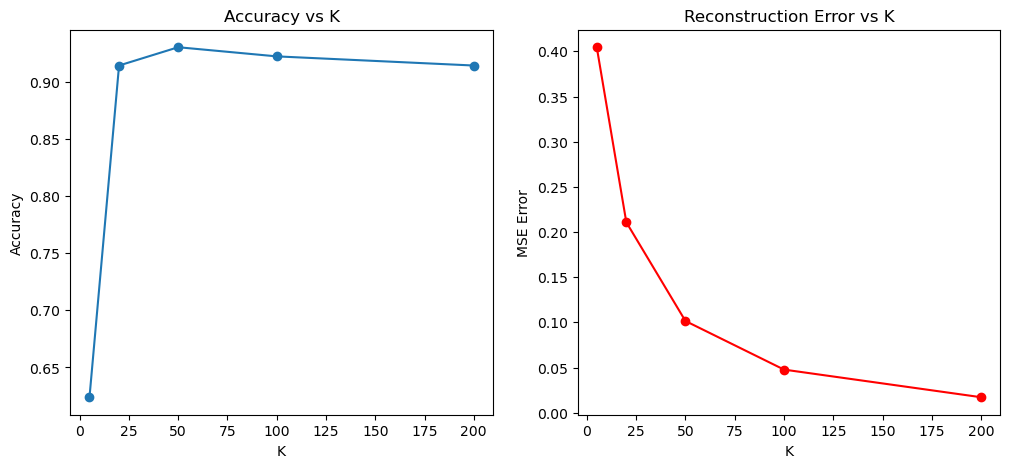

In [90]:
import matplotlib.pyplot as plt

k_list = [5, 20, 50, 100, 200]
accuracy_list = []
recon_error_list = []

X_mean = np.mean(X_train, axis=0)

for k in k_list:
    X_train_recon, U_k, S_k, VT_k = svd(X_train, k)
    X_test_recon = reconstruct_test(X_test, VT_k)
    
    y_pred = predict_labels(X_train_recon, y_train, X_test_recon)
    accuracy_list.append(accuracy_score(y_test, y_pred))
   
    error = reconstruction_error(X_train, X_train_recon)
    recon_error_list.append(error)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k_list, accuracy_list, marker='o')
plt.title("Accuracy vs K")
plt.xlabel("K")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(k_list, recon_error_list, marker='o', color='r')
plt.title("Reconstruction Error vs K")
plt.xlabel("K")
plt.ylabel("MSE Error")

plt.show()


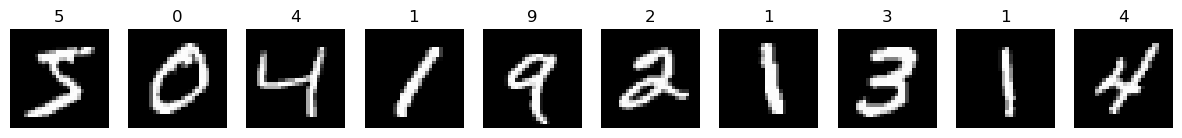

In [91]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(15, 2))  

for i in range(10):  
    axes[i].imshow(X[i].reshape(28, 28), cmap="gray")
    axes[i].set_title(f"{y[i]}")
    axes[i].axis("off")

plt.show()


In [92]:
def pca(X, k):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    cov_matrix = np.dot(X_centered.T, X_centered) / (X_centered.shape[0] - 1)

    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]

    U_k = eig_vecs[:, :k]

    X_train_proj = X_centered @ U_k

    X_train_recon = X_train_proj @ U_k.T + X_mean

    return X_train_proj, X_train_recon, U_k, X_mean


In [93]:
def project(X_test, U_k, X_mean):
    X_test_centered = X_test - X_mean
    X_test_proj = X_test_centered @ U_k
    X_test_recon = X_test_proj @ U_k.T + X_mean
    return X_test_proj, X_test_recon


In [94]:
def predict_label(X_train_recon, y_train, X_test_recon):
    y_pred = []
    for xt in X_test_recon:
        distances = np.linalg.norm(X_train_recon - xt, axis=1)
        nearest_idx = np.argmin(distances)
        y_pred.append(y_train[nearest_idx])
    return np.array(y_pred)


In [95]:
def reconstruction_error(X_original, X_reconstructed):
    return np.mean((X_original - X_reconstructed) ** 2)


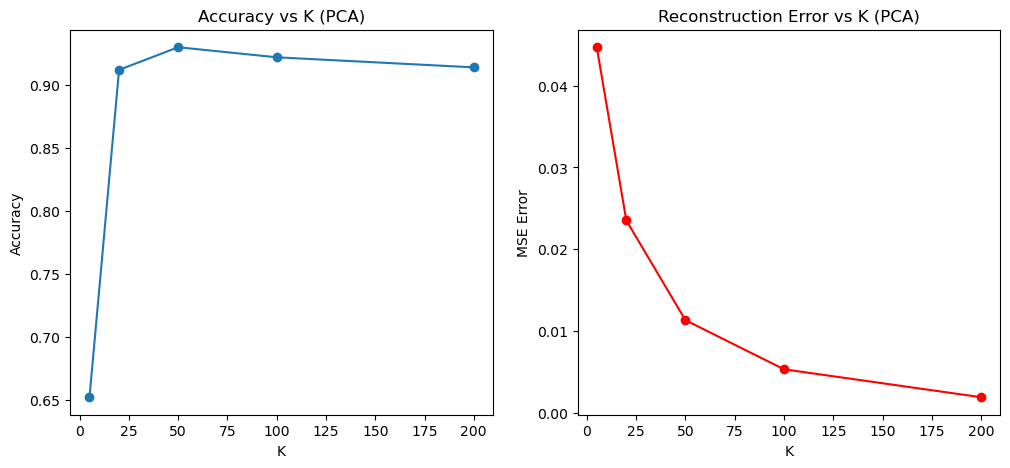

In [96]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_list = [5, 20, 50, 100, 200]
accuracy_list = []
recon_error_list = []

for k in k_list:
    
    X_train_proj, X_train_recon, U_k, X_mean = pca(X_train, k)
    
 
    X_test_proj, X_test_recon = project(X_test, U_k, X_mean)
   
    y_pred = predict_label (X_train_recon, y_train, X_test_recon)
    accuracy_list.append(accuracy_score(y_test, y_pred))
    
    
    error = reconstruction_error(X_train, X_train_recon)
    recon_error_list.append(error)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k_list, accuracy_list, marker='o')
plt.title("Accuracy vs K (PCA)")
plt.xlabel("K")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(k_list, recon_error_list, marker='o', color='r')
plt.title("Reconstruction Error vs K (PCA)")
plt.xlabel("K")
plt.ylabel("MSE Error")
plt.show()
